# Erste Analysen für aggregierte Daten

### Datenimport

Importieren und Zusammenfügen der aggregierten Daten von https://www.ckw.ch/lp/opendata.html 

Aggregierte Daten: Summierter Verbrauch pro Zeitfenster pro Gemeinde

In [1]:
%reset

In [1]:
# Verwendete Packages:

import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as md
%matplotlib inline
import datetime
import ics
from ics import Calendar
import calendar
from urllib.request import urlopen
from csv_ical import Convert
from dateutil import parser
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm

In [3]:
# Datenimport 2022

dfs22 = {} 
for i in range(202201, 202212):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs22["dataset{0}".format(i)] = loadData()

In [4]:
# Datenimport 2021

dfs21 = {}
for i in range(202101, 202113):   
    def loadData(month : int = i) -> pd.core.frame.DataFrame :
        url = "https://axsa4prod4publicdata4sa.blob.core.windows.net/$web/ckw_opendata_smartmeter_dataset_b_%i.csv.gz" % month
        return pd.read_csv(url)
    datasetname = i 
    dfs21["dataset{0}".format(i)] = loadData()

In [5]:
# Zusammenfügen

df_data = pd.DataFrame()
df_data = pd.concat([
    dfs22['dataset202201'],
    dfs22['dataset202202'], 
    dfs22['dataset202203'], 
    dfs22['dataset202204'], 
    dfs22['dataset202205'], 
    dfs22['dataset202206'], 
    dfs22['dataset202207'], 
    dfs22['dataset202208'],
    dfs22['dataset202209'],
    dfs22['dataset202210'],
    dfs22['dataset202211'],
    dfs21['dataset202101'],
    dfs21['dataset202102'], 
    dfs21['dataset202103'], 
    dfs21['dataset202104'], 
    dfs21['dataset202105'], 
    dfs21['dataset202106'], 
    dfs21['dataset202107'], 
    dfs21['dataset202108'],
    dfs21['dataset202109'],
    dfs21['dataset202110'],
    dfs21['dataset202111'],
    dfs21['dataset202112']
], ignore_index=True,axis=0)
df_data
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

### Datenaufbereitung

In [6]:
df_data = pd.read_pickle("Dataset.pkl")

In [7]:
# Formatierung von "timestamp"

df_data['timestamp'] = pd.to_datetime(df_data['timestamp']).dt.tz_convert('Europe/Berlin') # Anpassung Zeitzone auf CET
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format="%Y-%m-%dT%H:%M:%S.%fZ", errors = 'coerce') # Formatierung

In [8]:
# Datum-Variablen

df_data['date'] = df_data['timestamp'].dt.date # Datum
df_data["date"] = pd.to_datetime(df_data["date"], format='%Y-%m-%d') # Formatierung Datum
df_data['month'] = df_data['timestamp'].dt.month # Monat
df_data['year'] = df_data['timestamp'].dt.year # Jahr
df_data['timestamp'] = df_data['timestamp'].dt.time # Uhrzeit
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'], format='%H:%M:%S') # Formatierung Uhrzeit
df_data = df_data[~(df_data["year"]=="2020")] # Löschen der (vereinzelten) Werte aus 2020

In [9]:
print(df_data)
df_data.dtypes
df_data.to_pickle("Dataset.pkl") # Zwischenspeicherung Datenset

         area_code           timestamp  num_meter   value_kwh       date  \
0             6028 1900-01-01 12:30:00        131   23.682353 2022-01-28   
1             6028 1900-01-01 22:45:00        130   22.985000 2022-01-20   
2             6028 1900-01-01 14:30:00        130   24.486000 2022-01-04   
3             6028 1900-01-01 13:15:00        131   32.138353 2022-01-27   
4             6028 1900-01-01 10:45:00        130   37.359000 2022-01-14   
...            ...                 ...        ...         ...        ...   
7626229       6263 1900-01-01 19:30:00        442   93.188000 2021-12-14   
7626230       6263 1900-01-01 03:45:00        440  152.357000 2021-12-11   
7626231       6263 1900-01-01 11:30:00        440  104.941000 2021-12-10   
7626232       6263 1900-01-01 03:00:00        440  184.617000 2021-12-10   
7626233       6263 1900-01-01 11:30:00        441   82.090000 2021-12-27   

         month  year  
0            1  2022  
1            1  2022  
2            1  20

#### Zusammmenführen mit Gemeindegrössen

Öffentliche Einwohnerzahlen pro PLZ <br>
   * anzahl: Anzahl Einwohner pro PLZ per Stichtag 1.11.2022  <br>
   * typ: m=männlich, w=weiblich, f=firma

In [10]:
# Import öffentlicher Einwohnerzahlen pro PLZ

df_data = pd.read_pickle("Dataset.pkl")   
df_pop = pd.read_csv('https://swisspost.opendatasoft.com/api/v2/catalog/datasets/bevoelkerung_proplz/exports/csv', delimiter= ';')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9552 entries, 0 to 9551
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   stichdatum  9552 non-null   object 
 1   plz         9549 non-null   float64
 2   anzahl      9552 non-null   int64  
 3   typ         9552 non-null   object 
 4   ortbez18    9546 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 373.2+ KB


In [11]:
# Zusammenführen mit Verbrauchsdaten

df_pop.rename(columns={'plz':'area_code'}, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_pop, how="left", on=["area_code"]) # Left-join

In [12]:
# Reshape & Bereinigung 

df_data=df_data.pivot(index=['area_code', 'timestamp', 'num_meter', 'value_kwh', 'stichdatum', 'ortbez18', 'date', 'year', 'month'], \
columns='typ', values=['anzahl']).reset_index() # Typ-Kategorien von long- in shor-Format

df_data['num_habits']=df_data['anzahl','f'] + df_data['anzahl','m'] + df_data['anzahl','w'] # Berechnung Anzahl Einwohner pro Gemeinde
df_data.columns = df_data.columns.droplevel('typ') # Löschen Index-Hierarchie
del df_data['stichdatum'] # Löschen col Stichdatum
df_data.columns.values[8:11] =['num_f', 'num_m', 'num_w' ] # Umbenennen Variablen


In [13]:
df_data.to_pickle("Dataset01.pkl") # Zwischenspeicherung Datenset
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,num_w,num_habits
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,126,808,778,1712
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,126,808,778,1712
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,126,808,778,1712
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,126,808,778,1712
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,126,808,778,1712
...,...,...,...,...,...,...,...,...,...,...,...,...
7626229,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,953,907,2080
7626230,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,953,907,2080
7626231,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,953,907,2080
7626232,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,953,907,2080


#### Import öffentlicher Wetterdaten 
* tre200d0 = °C Lufttemperatur 2 m über Boden; Tagesmittel
* prestad0 = hPa Luftdruck auf Stationshöhe (QFE); Tagesmittel
    

In [14]:
# Import Daten 2022

df_data = pd.read_pickle("Dataset01.pkl")
df_temp22= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_current.csv', delimiter= ';') 
df_temp22=df_temp22[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp22["date"] = pd.to_datetime(df_temp22["date"], format='%Y%m%d')
df_temp22.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)


In [15]:
# Import Daten 2021

df_temp21= pd.read_csv('https://data.geo.admin.ch/ch.meteoschweiz.klima/nbcn-tageswerte/nbcn-daily_LUZ_previous.csv', delimiter= ';') # 2021
df_temp21=df_temp21[['tre200d0', 'prestad0', 'station/location', 'date']]
df_temp21["date"] = pd.to_datetime(df_temp21["date"], format='%Y%m%d')
df_temp21.rename(columns={'tre200d0':'daytemp','prestad0': "airpress"}, inplace=True)

In [16]:
# Zusammenführen mit Verbrauchsdaten

df_temp = pd.concat([df_temp22, df_temp21], ignore_index=True,axis=0) # Zusammenfügen Wetterdaten 2021 & 2022
df_data = pd.merge(df_data, df_temp, how="left", on=["date"]) # Merge mit Verbrauchsdaten
df_data
df_data.to_pickle("Dataset02.pkl") # Zwischenspeicherung Datenset

#### Import Daten zum Smart Meter Rollout

In [17]:
df_data = pd.read_pickle("Dataset02.pkl")

In [18]:
# Auszug von Gemeinde- und PLZ-Daten

df_areas=df_data.sort_values('ortbez18', ascending=False).groupby('area_code').head(1)
df_areas =  df_areas[["area_code", "ortbez18"]]
df_areas=pd.DataFrame(df_areas)
df_areas.to_excel(r'C:\Users\ckw-stea\OneDrive - CKW-Gruppe\Desktop\Python\Smart Meter\Gemeinden_SM.xlsx', index=False)

In [19]:
# Import Daten zum Smart Meter Rollout 

df_SM = pd.read_excel(r'C:\Users\ckw-stea\OneDrive - CKW-Gruppe\Desktop\Python\Smart Meter\SM Rollout.xlsx') # Import Daten
df_SM.rename({"PLZ": "area_code"}, axis=1, inplace=True) # Umbenennen PLZ-Spalte
df_data = pd.merge(df_data, df_SM, how="left", on=["area_code"]) # Merge mit Verbrauchsdaten

#### Zusätzliche Variablen

In [20]:
#Durchschnittlicher Verbrauch pro Smart Meter pro Gemeinde

df_data['kwh_permeterarea'] = df_data['value_kwh']/df_data['num_meter']

In [21]:
# Durchschnittlicher Verbrauch pro Smart Meter pro 15-min-Zeitfenster

df_data['kwh_perdatetime']=df_data.groupby(['date', 'timestamp'])['value_kwh'].transform('sum') # Total kwh pro Timeframe über alle Gemeinden
df_data['sm_perdatetime']=df_data.groupby(['date', 'timestamp'])['num_meter'].transform('sum') # Anzahl Smart Meter pro Timeframe über alle Gemeinden 
df_data['kwh_persmdt']=df_data['kwh_perdatetime']/df_data['sm_perdatetime'] # kwh pro Timeframe pro Smart Meter


In [22]:
# Ergänzung Saison 

df_data.loc[(df_data['month'] == 12) | (df_data['month'] == 1) | (df_data['month'] == 2) , 'season'] = 'Winter' # Neue Spalte mit "Winter" für Wintermonate
df_data.loc[(df_data['month'] == 3) | (df_data['month'] == 4) | (df_data['month'] == 5) , 'season'] = 'Frühling' # "Frühling" für Frühlingsmonate
df_data.loc[(df_data['month'] == 6) | (df_data['month'] == 7) | (df_data['month'] == 8) , 'season'] = 'Sommer' # "Sommer" für Sommermonate
df_data.loc[(df_data['month'] == 9) | (df_data['month'] == 10) | (df_data['month'] == 11) , 'season'] = 'Herbst' # "Herbst" für Herbstmonate

In [23]:
 # Hinzufügen Wochentag

df_data['weekday']= df_data['date'].dt.day_name()

In [24]:
df_data.to_pickle("Dataset03.pkl") # Zwischenspeicherung Datenset
df_data.sort_values(['date', 'timestamp'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,airpress,station/location,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday
0,4806,1900-01-01 00:00:00,19,4.450000,Wikon,2021-01-01,2021,1,126,808,...,953.9,LUZ,2021-03-26,2021-03-31,0.234211,13521.100398,38951,0.347131,Winter,Friday
194193,6005,1900-01-01 00:00:00,112,25.415000,Luzern/St. Niklausen LU,2021-01-01,2021,1,3201,12669,...,953.9,LUZ,2023-08-01,2023-08-27,0.226920,13521.100398,38951,0.347131,Winter,Friday
261293,6010,1900-01-01 00:00:00,93,11.088188,Pilatus Kulm/Kriens,2021-01-01,2021,1,2551,14526,...,953.9,LUZ,2023-05-25,2023-07-31,0.119228,13521.100398,38951,0.347131,Winter,Friday
261294,6010,1900-01-01 00:00:00,1707,199.815000,Pilatus Kulm/Kriens,2021-01-01,2021,1,2551,14526,...,953.9,LUZ,2023-05-25,2023-07-31,0.117056,13521.100398,38951,0.347131,Winter,Friday
328454,6014,1900-01-01 00:00:00,27,10.531000,Luzern,2021-01-01,2021,1,1273,5780,...,953.9,LUZ,2023-03-27,2023-03-28,0.390037,13521.100398,38951,0.347131,Winter,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7364492,6288,1900-01-01 22:45:00,619,110.519000,Schongau,2022-11-30,2022,11,130,612,...,965.7,LUZ,2021-06-02,2021-06-06,0.178544,13960.537125,106128,0.131544,Herbst,Wednesday
7431706,6289,1900-01-01 22:45:00,608,87.875500,Hämikon/Müswangen,2022-11-30,2022,11,123,662,...,965.7,LUZ,2021-06-02,2021-06-04,0.144532,13960.537125,106128,0.131544,Herbst,Wednesday
7498690,6294,1900-01-01 22:45:00,620,84.417000,Ermensee,2022-11-30,2022,11,117,614,...,965.7,LUZ,2021-05-20,2021-05-24,0.136156,13960.537125,106128,0.131544,Herbst,Wednesday
7556502,6295,1900-01-01 22:45:00,228,32.471000,Mosen,2022-11-30,2022,11,45,182,...,965.7,LUZ,2021-05-10,2021-05-10,0.142417,13960.537125,106128,0.131544,Herbst,Wednesday


#### Ergänzung von Feiertagen und Ferien

In [25]:
df_data = pd.read_pickle("Dataset03.pkl")

In [26]:
# Import Schulferien-Kalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2021.ics?k=X1-tbnx2FDD-JES_XUvgkPZvrwnD_7Eg5QILxcWCnN54JcWmszYrnbbROEQwNAlSBe75Tf5i_KEDZXYEyFPYdb2vr5HYCo3dpCMfIHMmWig' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [27]:
# Import Schulferien-Kalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/ferien_luzern_alle-schulen_2022.ics?k=-HeiXBRn4cEMJC0g6GpsW4cwS7i_b0Hs7tsswy8bHRUVop65bjCsQJsMkxQUCgPrygs9IZeQTkvkKG_P4z_xNkk6Fg0PXj9nDQ7H-z__IKE'

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
school22 = icsFile.events
events.update(school22) # Hinzufügen zu Events
events

{<all-day Event 'Sportferien 2021 Luzern' begin:2021-02-06 end:2021-02-22>,
 <all-day Event 'FrÃ¼hlingsferien 2021 Luzern' begin:2021-04-02 end:2021-04-19>,
 <all-day Event 'Sommerferien 2021 Luzern' begin:2021-07-10 end:2021-08-23>,
 <all-day Event 'Herbstferien 2021 Luzern' begin:2021-10-02 end:2021-10-18>,
 <all-day Event 'Weihnachtsferien 2021 Luzern' begin:2021-12-18 end:2022-01-03>,
 <all-day Event 'Sportferien 2022 Luzern' begin:2022-02-19 end:2022-03-07>,
 <all-day Event 'FrÃ¼hlingsferien 2022 Luzern' begin:2022-04-15 end:2022-05-02>,
 <all-day Event 'Sommerferien 2022 Luzern' begin:2022-07-09 end:2022-08-22>,
 <all-day Event 'Herbstferien 2022 Luzern' begin:2022-10-01 end:2022-10-17>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-09 end:2022-12-10>,
 <all-day Event 'Weihnachtsferien 2022 Luzern' begin:2022-12-24 end:2023-01-09>}

In [28]:
# Ergänzung Ferien im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(schoolhol = holidayCheck) # Neue Spalte mit Ferienindikator

In [29]:
# Import Feiertagskalender Kanton Luzern 2021

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2021.ics?k=6LaiL2FVxUpK0nKXOZLWVBXS4KTyruz76LOzri9flPxd5iwVANFz74HoRBUszjAk-JWoWFNCyNqJqdsRaVvo1UUSHV7Ssevj85XsPpCQUtA' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
events = icsFile.events

In [30]:
# Import Feiertagskalender Kanton Luzern 2022

url = 'https://www.schulferien.org/media/ical/schweiz/feiertage_luzern_2022.ics?k=Lmxggzt9kYC0jKx4fu-BijSs_RyNiOdPeXaG-ag_QdWyJloVtnoqL_0w80bdIeZ2SU2DOGB9gOr3ATat4H1IBAa1Ffa0y89pEnD_iYnopgo' 

icsFile = ics.Calendar(urlopen(url).read().decode('iso-8859-1'))
holidays22 = icsFile.events
events.update(holidays22) # Hinzufügen zu Events
events

{<all-day Event 'Neujahr' begin:2021-01-01 end:2021-01-02>,
 <all-day Event 'Josefstag' begin:2021-03-19 end:2021-03-20>,
 <all-day Event 'Karfreitag' begin:2021-04-02 end:2021-04-03>,
 <all-day Event 'Ostermontag' begin:2021-04-05 end:2021-04-06>,
 <all-day Event 'Auffahrt' begin:2021-05-13 end:2021-05-14>,
 <all-day Event 'Pfingstmontag' begin:2021-05-24 end:2021-05-25>,
 <all-day Event 'Fronleichnam' begin:2021-06-03 end:2021-06-04>,
 <all-day Event 'Peter und Paul' begin:2021-06-29 end:2021-06-30>,
 <all-day Event 'Nationalfeiertag' begin:2021-08-01 end:2021-08-02>,
 <all-day Event 'Eidg. Dank-\, Buss- und Bettag' begin:2021-09-19 end:2021-09-20>,
 <all-day Event 'Allerheiligen' begin:2021-11-01 end:2021-11-02>,
 <all-day Event 'MariÃ¤ EmpfÃ¤ngnis' begin:2021-12-08 end:2021-12-09>,
 <all-day Event 'Weihnachten' begin:2021-12-25 end:2021-12-26>,
 <all-day Event 'Stephanstag' begin:2021-12-26 end:2021-12-27>,
 <all-day Event 'Neujahr' begin:2022-01-01 end:2022-01-02>,
 <all-day Event

In [31]:
# Ergänzung Feiertage im Datenset

holidayCheck = []
for _datetime in df_data['date']:

    dfDate = int(_datetime.strftime('%Y%m%d')) # Datetime-Variable "date" in String konvertieren
    
    check = False
    for event in events: 
        eventStart = int(event.begin.strftime('%Y%m%d')) # Event-Startdatum in String konvertieren
        eventEnd = int(event.end.strftime('%Y%m%d')) # Event-Enddatum in String konvertieren

        if (dfDate >= eventStart) and (dfDate < eventEnd) : # Check für jedes Datum, ob von Ferien- oder Feiertag betroffen
            holidayCheck.append(1)
            check = True
            break
        else:
            check = False
            
    if check == False:
        holidayCheck.append(0)

df_data = df_data.assign(holiday = holidayCheck) # Neue Spalte mit Ferien-/Feiertagindikator

In [32]:
df_data.to_pickle("Dataset04.pkl") # Zwischenspeicherung Datenset

In [64]:
df_data

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday,schoolhol,holiday
0,4806,1900-01-01 00:00:00,19,4.45000,Wikon,2021-01-01,2021,1,126,808,...,2021-03-26,2021-03-31,0.234211,13521.100398,38951,0.347131,Winter,Friday,0,1
1,4806,1900-01-01 00:00:00,24,4.69300,Wikon,2021-01-25,2021,1,126,808,...,2021-03-26,2021-03-31,0.195542,10814.948846,47207,0.229096,Winter,Monday,0,0
2,4806,1900-01-01 00:00:00,24,4.78400,Wikon,2021-01-22,2021,1,126,808,...,2021-03-26,2021-03-31,0.199333,9171.829166,42452,0.216052,Winter,Friday,0,0
3,4806,1900-01-01 00:00:00,24,4.92200,Wikon,2021-01-08,2021,1,126,808,...,2021-03-26,2021-03-31,0.205083,10115.856275,40186,0.251726,Winter,Friday,0,0
4,4806,1900-01-01 00:00:00,24,5.08800,Wikon,2021-01-26,2021,1,126,808,...,2021-03-26,2021-03-31,0.212000,11189.340653,45132,0.247925,Winter,Tuesday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7626229,6344,1900-01-01 23:45:00,925,161.78300,Meierskappel,2022-04-25,2022,4,220,953,...,2021-08-31,2021-09-10,0.174901,14456.019445,104492,0.138346,Frühling,Monday,1,0
7626230,6344,1900-01-01 23:45:00,926,151.60475,Meierskappel,2022-09-26,2022,9,220,953,...,2021-08-31,2021-09-10,0.163720,12604.378570,106231,0.118651,Herbst,Monday,0,0
7626231,6344,1900-01-01 23:45:00,928,96.54700,Meierskappel,2022-09-01,2022,9,220,953,...,2021-08-31,2021-09-10,0.104038,9141.273673,106204,0.086073,Herbst,Thursday,0,0
7626232,6344,1900-01-01 23:45:00,928,97.69100,Meierskappel,2022-06-30,2022,6,220,953,...,2021-08-31,2021-09-10,0.105270,9139.271473,105309,0.086785,Sommer,Thursday,0,0


### Grafiken

#### Smart Meter Rollout

In [2]:
df_data = pd.read_pickle("Dataset04.pkl")
sns.set_theme() # definiere Seaborn als Plot-Stil
sns.set(font_scale=1.1) # Anpassung Default-Schriftgrösse

In [3]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month','date'])[['sm_perdatetime']].mean() # Anzahl Smart Meter pro Tag
df_day = df_day.reset_index() # Index-Hierarchie aufheben

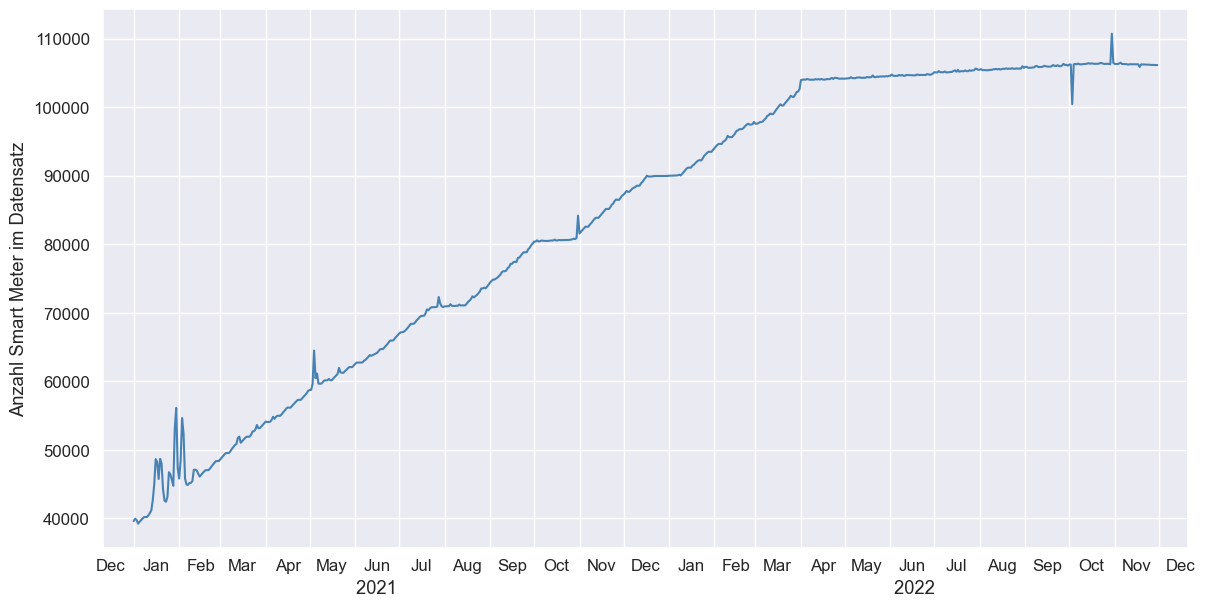

In [5]:
fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['sm_perdatetime'], color = 'steelblue')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator())
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Minor tick labels anpassen
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

ax.set_xlabel("2021                                                                                                 2022")

plt.ylabel("Anzahl Smart Meter im Datensatz") # Y-Label
plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()


#### Verbrauch 2021 / 2022

In [77]:
# Datenaufbereitung

df_data['daymonth'] = df_data['date'] .dt.strftime('%m-%d') # Variable mit Tag-Monat
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year', 'month', 'daymonth', 'date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_dayroll=df_day # Dataframe für rollierenden Verbrauch
df_dayroll['rollkwh'] = df_dayroll['kwh_persmdt'].rolling(7).mean() # rollierender Verbrauch über letzte 7 Tage

df_day=df_day.pivot_table(values="kwh_persmdt", index=['month','daymonth'], columns=["year"]).reset_index() # Pivot-Tabelle
df_day.columns = ['month','date', '2021', '2022'] # Umbenennen Variablen

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_14620\1341960861.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) # x-Tick-Labels


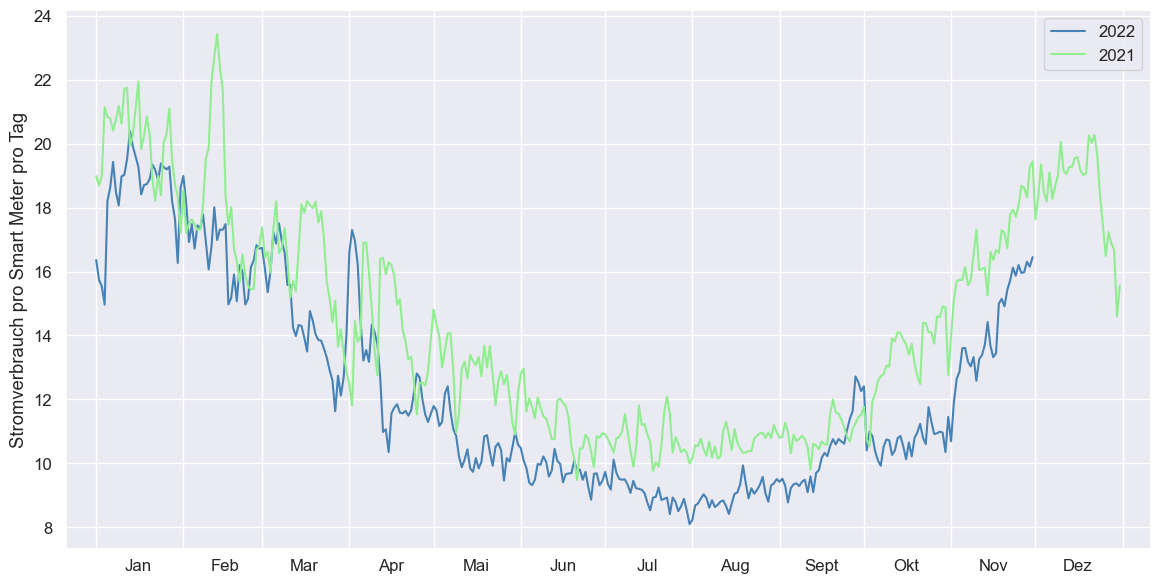

In [85]:
# Grafik mit Verbrauch pro Tag

fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_day['date'], df_day['2022'], color = 'steelblue', label='2022')
ax.plot(df_day['date'], df_day['2021'], color = 'lightgreen', label='2021')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator(bymonth=range(1,13,1))) # X-Ticks pro Monat
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Position Minor tick labels:
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) #  Anpassen Labels
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag") # Y-Label
ax.legend() # Hinzufügen Legende

plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_14620\973445109.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) #  Anpassen Labels


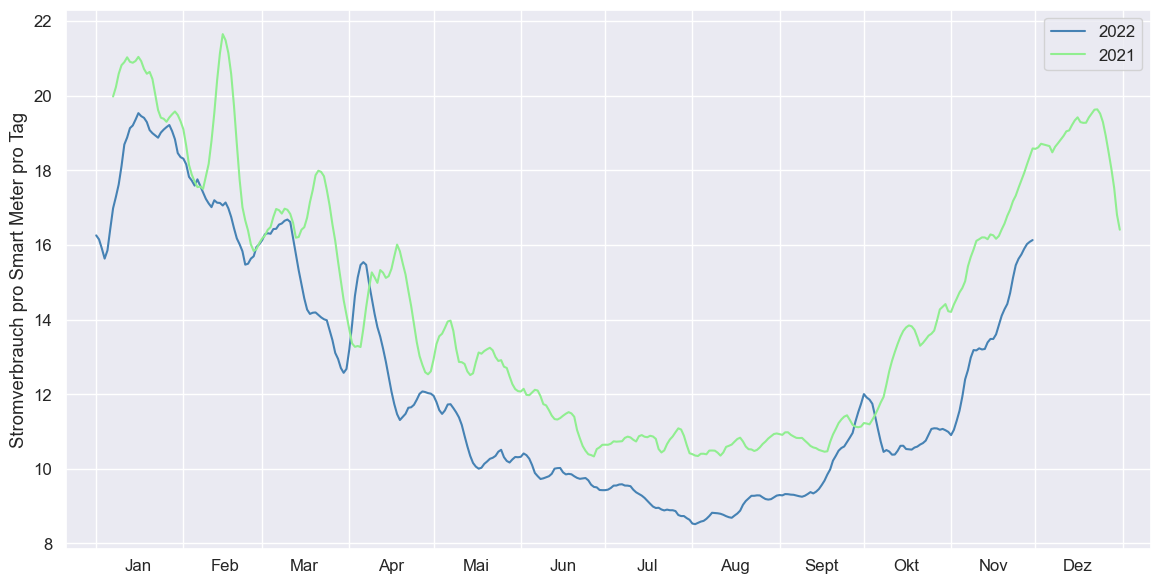

In [87]:
# Grafik mit rollierendem Verbrauch über letzte 7 Tage

df_dayroll=df_dayroll.pivot_table(values="rollkwh", index=['month','daymonth'], columns=["year"]).reset_index() # Pivot-Tabelle
df_dayroll.columns = ['month','date', '2021', '2022'] # Umbenennen Variablen

fig, ax = plt.subplots(figsize = (14,7)) 

ax.plot(df_dayroll['date'], df_dayroll['2022'], color = 'steelblue', label='2022')
ax.plot(df_dayroll['date'], df_dayroll['2021'], color = 'lightgreen', label='2021')

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator(bymonth=range(1,13,1))) # X-Ticks pro Monat
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor-Ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Position Minor tick labels:
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
    #label.set_rotation(45)

#ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov', 'Dez'], minor=True) #  Anpassen Labels
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag") # Y-Label
ax.legend() # Hinzufügen Legende

plt.margins(x=0.03) # Anpassen Seitenrand
plt.show()

#### Verbrauch pro Smart Meter über Wochentage

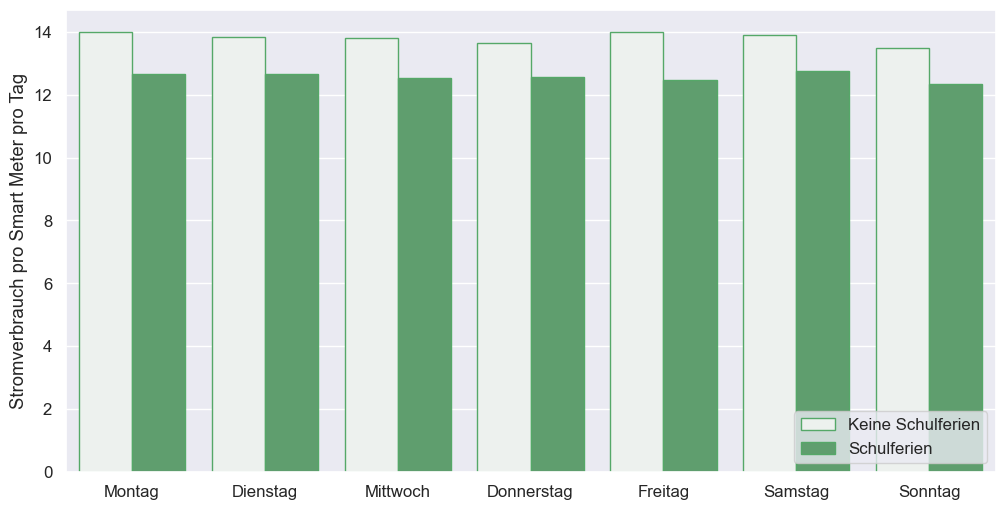

In [37]:
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'weekday','schoolhol','date'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag
df_day=df_day.groupby(['schoolhol','weekday'])[['kwh_persmdt']].mean() # Durchschnittlicher Verbrauch pro Wochentag

df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_day['weekday'] = df_day['weekday'].astype("category") # Kategorie-Typ für Wochentage festlegen
df_day['weekday'] = df_day['weekday'].cat.set_categories(["Monday", "Tuesday", 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True) # Daten nach Wochentagen ordnen

plt.figure(figsize=(12,6)) # Grafik-Grösse
ax=sns.barplot(x='weekday', y='kwh_persmdt', hue='schoolhol', data=df_day, color = 'g', edgecolor = 'g') 
ax.set(xlabel=None, ylabel="Stromverbrauch pro Smart Meter pro Tag") # X-Label aufheben & Y-Label benennen
ax.set_xticklabels(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']) # x-Tick-Labels

labels=["Keine Schulferien","Schulferien"] # Legenden-Labels
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, title=None, loc='lower right') # Positionierung Legende

plt.show()

In [163]:
# Verbrauchsunterschiede nach Wochentagen & Ferien in Zahlen

df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'date'], as_index=False).agg({'kwh_persmdt': 'sum', 'schoolhol': 'first',  'holiday': 'first', 'weekday': 'first'}) # Verbrauch pro Smart Meter pro Tag

def categorise (row):  
    if row['weekday'] == "Sunday" or row['holiday']==1:
        return '1'
    return '0'

df_day['Sunday'] = df_day.apply(lambda row: categorise(row), axis=1)
df_day=df_day.groupby(['Sunday'])[['kwh_persmdt']].mean() # Durchschnittlicher Verbrauch Sonntag vs. Wochentag

print(df_day)
print("Differenz Sonntag vs. Wochentag:",round(df_day.iloc[0,0]-df_day.iloc[1,0], 2))
print("Sonntag vs. Wochentag in %:", round(((df_day.iloc[0,0]-df_day.iloc[1,0])/df_day.iloc[1,0])*100, 2)) # Unterschied Sonntag vs. Wochentag in %
print("MWh-Einsparung pro Tag Schweiz:", round(((df_day.iloc[0,0]-df_day.iloc[1,0])*5100000)/1000, 2)) # Total MWh-Einsparung pro Tag während Sonntagen bei 5.1 Mio Endkunden in der Schweiz
print("kcal pro Tag pro Zählpunkt:", round((df_day.iloc[0,0]-df_day.iloc[1,0])*860, 2)) # Umrechnung kcal pro Tag pro Zählpunkt

df_day=df_datashort.groupby(['year','month', 'date'], as_index=False).agg({'kwh_persmdt': 'sum', 'schoolhol': 'first',  'holiday': 'first', 'weekday': 'first'}) # Verbrauch pro Smart Meter pro Tag
df_day=df_day.groupby(['schoolhol'])[['kwh_persmdt']].mean() # Durchschnittlicher Verbrauch Schulferien vs. Schulzeit

print(df_day)
print("Differenz Schulferien vs. Schulzeit:",round(df_day.iloc[0,0]-df_day.iloc[1,0], 2))
print("Schulferien vs. Schulzeit in %:", round(((df_day.iloc[0,0]-df_day.iloc[1,0])/df_day.iloc[1,0])*100, 2)) # Unterschied Schulferien vs. Schulzeit in %
print("MWh-Einsparung pro Tag Schweiz:", round(((df_day.iloc[0,0]-df_day.iloc[1,0])*5100000)/1000, 2)) # Total MwH-Einsparung pro Tag während Schulferien bei 5.1 Mio Endkunden in der Schweiz
print("kcal pro Tag pro Zählpunkt:", round((df_day.iloc[0,0]-df_day.iloc[1,0])*860, 2)) # Umrechnung kcal pro Tag pro Zählpunkt

        kwh_persmdt
Sunday             
0         13.542607
1         13.055394
Differenz Sonntag vs. Wochentag: 0.49
Sonntag vs. Wochentag in %: 3.73
MWh-Einsparung pro Tag Schweiz: 2484.79
kcal pro Tag pro Zählpunkt: 419.0
           kwh_persmdt
schoolhol             
0            13.820273
1            12.567593
Differenz Schulferien vs. Schulzeit: 1.25
Schulferien vs. Schulzeit in %: 9.97
MWh-Einsparung pro Tag Schweiz: 6388.67
kcal pro Tag pro Zählpunkt: 1077.3


#### Temperatur und Verbrauch

In [97]:
# Datenaufbereitung

df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_day=df_datashort.groupby(['year','month', 'date', 'daytemp'])[['kwh_persmdt']].sum() # Verbrauch pro Smart Meter pro Tag über alle Gemeinden
df_day = df_day.reset_index() # Index-Hierarchie aufheben
df_dayroll = df_day
df_dayroll['rollkwh'] = df_dayroll['kwh_persmdt'].rolling(7).mean() # rollierender Verbrauch über letzte 7 Tage
df_dayroll['rolltemp'] = df_dayroll['daytemp'].rolling(7).mean() # rollierender mittlere Temparatur über letzte 7 Tage

df_dayroll = df_dayroll[~(df_dayroll['date'] < '2022-01-01')] # Nur Daten aus 2022

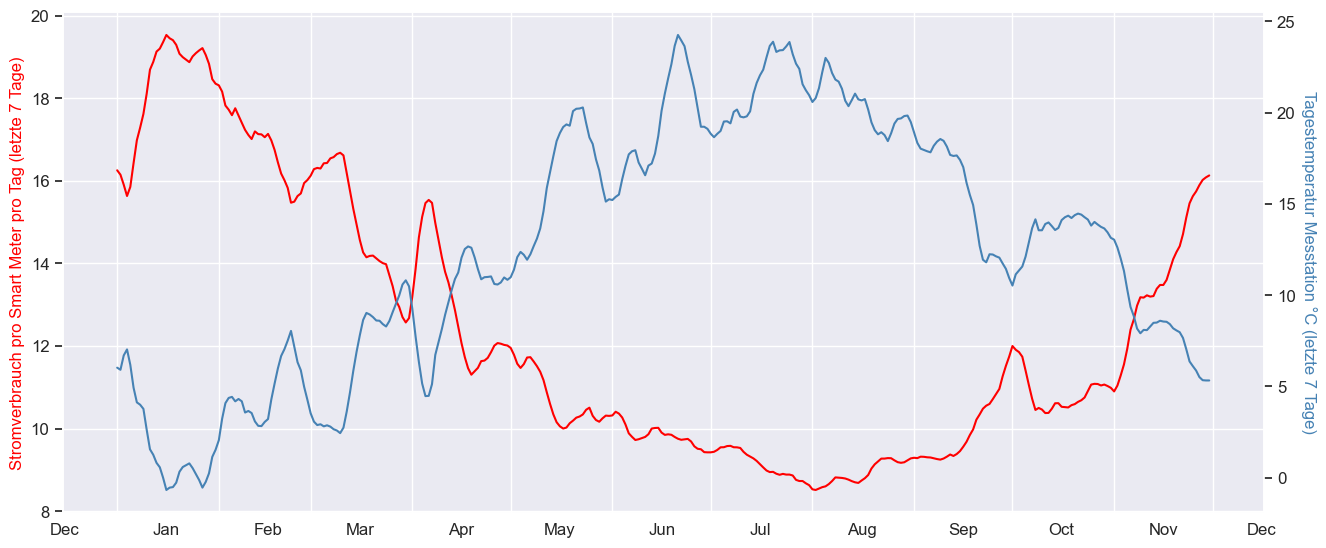

In [123]:
# Grafik

col1 = 'red' # Farben definieren
col2 = 'steelblue'

fig,ax = plt.subplots() # Subplots definieren
fig.set_size_inches(15.5, 6.5)

ax.plot(df_dayroll['date'], df_dayroll['rollkwh'], color=col1) # Verbrauch zum Plot hinzufügen

ax2 = ax.twinx() # zweite Achse definieren
ax2.plot(df_dayroll['date'], df_dayroll['rolltemp'], color=col2) # Temperatur zum Plot hinzufügen
ax2.set_ylabel('Tagestemperatur Messtation °C (letzte 7 Tage)', color=col2, fontsize=12, rotation=270, labelpad=15)  # Beschriftung 2. Achse
ax2.grid(False) # keine Hilfslinien für 2. Achse

# Zentrierte X-Achsen Labels 
ax.xaxis.set_major_locator(md.MonthLocator(bymonth=range(1,13,1))) # X-Ticks pro Monat
ax.xaxis.set_minor_locator(md.MonthLocator(bymonthday=16)) # Positionierung Minor-Ticks in Monatsmitte

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(md.DateFormatter('%b'))

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False) # Minor ticks entfernen

# Position Minor tick labels:
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')

#xlabels=[' ', 'Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sept', 'Okt','Nov'] #  Anpassen Labels
ax.set_ylabel('Stromverbrauch pro Smart Meter pro Tag (letzte 7 Tage)', color=col1, fontsize=12) # Y-Achsen-Beschriftung

plt.show()

#### Verbrauch pro Smart Meter über Tageszeit

In [8]:
df_time=df_data.pivot_table(values="kwh_persmdt", index="timestamp").reset_index() # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Saison

In [9]:
df_time

,timestamp,kwh_persmdt
0,1900-01-01 00:00:00,0.159740
1,1900-01-01 00:15:00,0.153986
2,1900-01-01 00:30:00,0.147543
3,1900-01-01 00:45:00,0.145202
4,1900-01-01 01:00:00,0.164508
...,...,...
91,1900-01-01 22:45:00,0.113786
92,1900-01-01 23:00:00,0.147007
93,1900-01-01 23:15:00,0.153441
94,1900-01-01 23:30:00,0.144822


<function matplotlib.pyplot.show(close=None, block=None)>

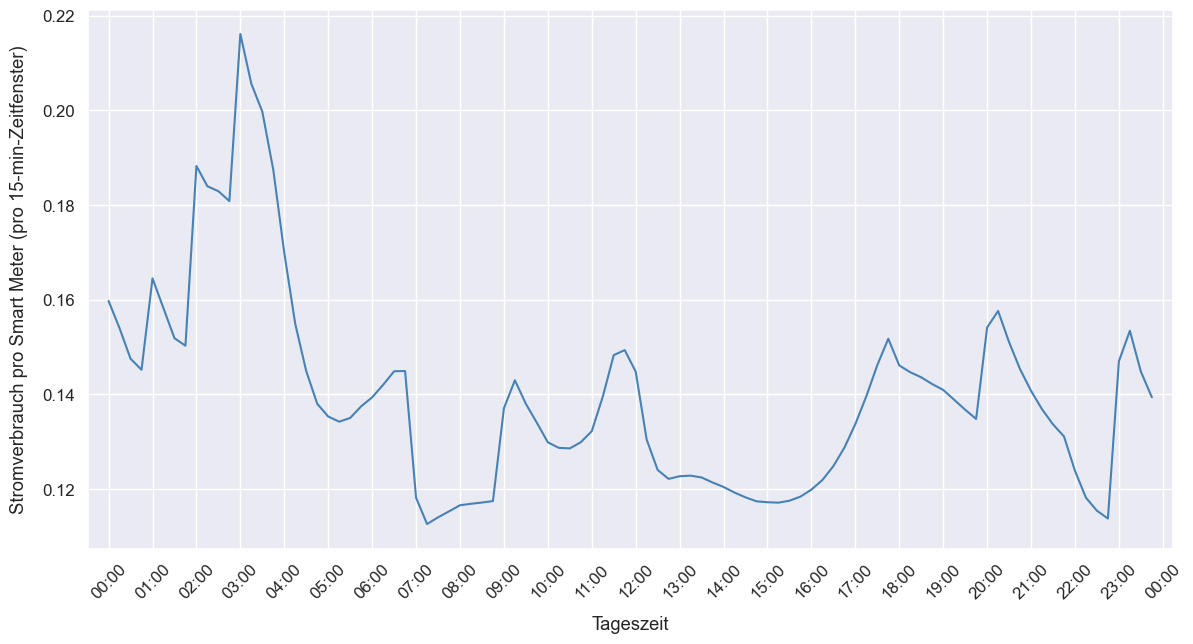

In [12]:
# Verbrauch über Tageszeit

df_time=df_data.pivot_table(values="kwh_persmdt", index="timestamp").reset_index() # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster

fig, ax = plt.subplots(figsize = (14,7)) # Grafik-Grösse

ax.plot(df_time["timestamp"], df_time['kwh_persmdt'], color = 'steelblue')

plt.xlabel("Tageszeit", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (pro 15-min-Zeitfenster)", labelpad=10) # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

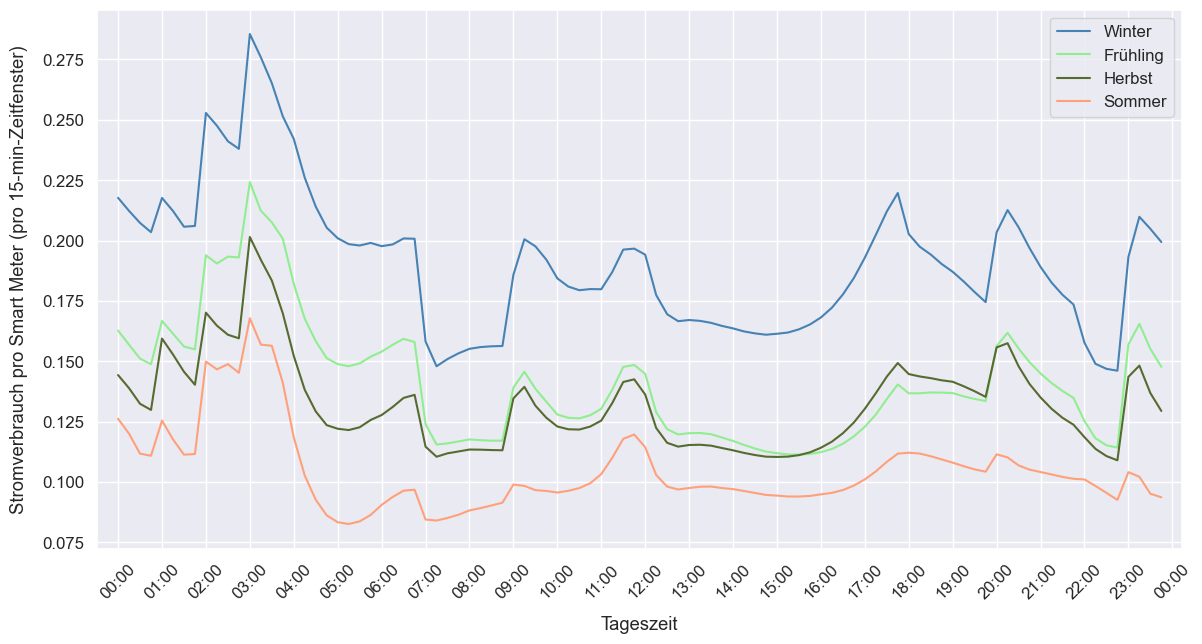

In [60]:
# Verbrauch über Tageszeit & Saison 

df_time=df_data.pivot_table(values="kwh_persmdt", index="timestamp", columns="season") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Saison

fig, ax = plt.subplots(figsize = (14,7)) # Grafik-Grösse

ax.plot(df_time.index, df_time['Winter'], color = 'steelblue', label='Winter')
ax.plot(df_time.index, df_time['Frühling'], color = 'lightgreen', label='Frühling')
ax.plot(df_time.index, df_time['Herbst'], color = 'darkolivegreen', label='Herbst')
ax.plot(df_time.index, df_time['Sommer'], color = 'lightsalmon', label='Sommer')

plt.xlabel("Tageszeit", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (pro 15-min-Zeitfenster)", labelpad=10) # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Effekt CH-Nati-Spiel

In [39]:
gamedate = datetime.datetime(2022, 11, 28) # Datum Nati-Spiel
weekday = gamedate.strftime('%A') # Wochentag Nati-Spiel

In [40]:
# Spalte mit Vergleichstagen für Analyse

df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) & (df_data['date']!= gamedate) & (df_data['year']==2022) , 'game'] = 'Vergleich 2022' # Markierung gleiche Wochentage im gleichen Monat 2022
df_data.loc[(df_data['month'] == gamedate.month) & (df_data['weekday'] ==  weekday) &  (df_data['year']==2021), 'game'] = 'Vergleich 2021' # Markeitung gleiche Wochentage im gleichen Monat im 2021
df_data.loc[(df_data['date'] == gamedate) , 'game'] = 'Spieltag' # Markierung Datum Nati-Spiel

In [41]:
time_range = (df_data['timestamp'].dt.hour >= 11) & (df_data['timestamp'].dt.hour <= 22) # Definition Zeitspanne für Visualisierung
df_game = df_data.loc[time_range] # Datenset-Ausschnitt basierend auf Zeitspanne

<function matplotlib.pyplot.show(close=None, block=None)>

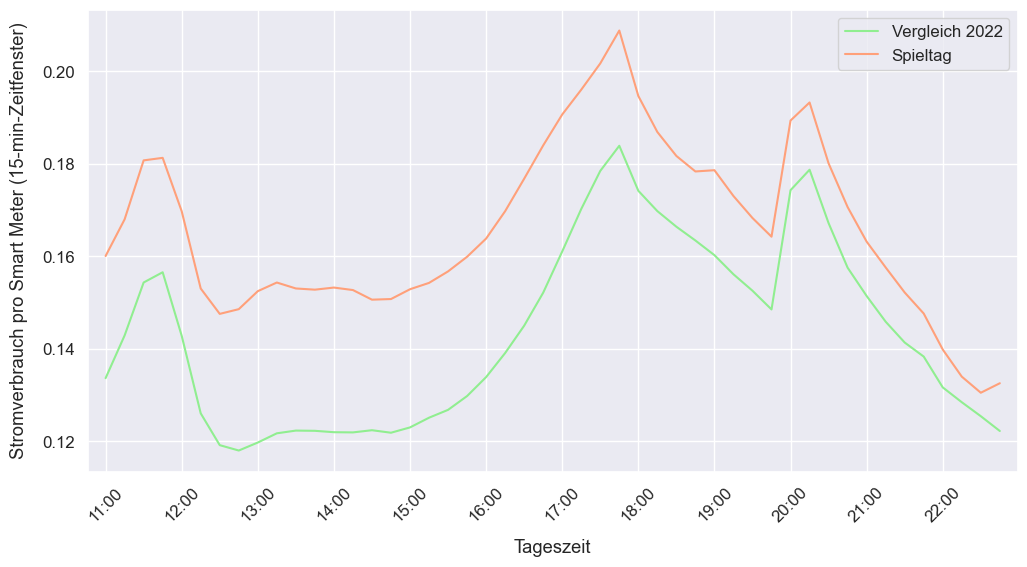

In [42]:
df_game=df_game.pivot_table(values="kwh_persmdt", index="timestamp", columns="game") # Pivot-Tabelle mit durchschnittlichem Verbrauch pro Zeitfenster und Spieltag / Vergleichstage

fig, ax = plt.subplots(figsize = (12,6)) # Grafik-Grösse

#ax.plot(df_game.index, df_game['Vergleich 2021'], color = 'steelblue', label='Vergleich 2021')
ax.plot(df_game.index, df_game['Vergleich 2022'], color = 'lightgreen', label='Vergleich 2022')
ax.plot(df_game.index, df_game['Spieltag'], color = 'lightsalmon', label='Spieltag')


plt.xlabel("Tageszeit", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (15-min-Zeitfenster)", labelpad=10) # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Stromverbrauch in den Gemeinden

In [37]:
df_data = pd.read_pickle("Dataset04.pkl") # Neueinlesen Daten 

In [57]:
# Ausschluss PLZ mit Rollout-Ende nach 1.1.2022

df_rollout = df_data[df_data['Ende Rollout'] < datetime.datetime(2022, 1, 1)]
df_rollout.sort_values(by=['Ende Rollout'])

,area_code,timestamp,num_meter,value_kwh,ortbez18,date,year,month,num_f,num_m,...,Start Rollout,Ende Rollout,kwh_permeterarea,kwh_perdatetime,sm_perdatetime,kwh_persmdt,season,weekday,schoolhol,holiday
3833102,6173,1900-01-01 05:15:00,820,70.303500,Flühli LU,2022-08-15,2022,8,135,668,...,2014-01-01,2014-05-01,0.085736,7100.074746,105481,0.067311,Sommer,Monday,1,0
3974417,6182,1900-01-01 07:45:00,1667,207.537195,Escholzmatt,2021-01-24,2021,1,244,1515,...,2014-01-01,2014-05-01,0.124497,5915.835466,43076,0.137335,Winter,Sunday,0,0
3974418,6182,1900-01-01 07:45:00,1734,253.145790,Escholzmatt,2021-01-26,2021,1,244,1515,...,2014-01-01,2014-05-01,0.145989,8309.819194,45891,0.181077,Winter,Tuesday,0,0
3974419,6182,1900-01-01 07:45:00,1737,207.758914,Escholzmatt,2021-05-06,2021,5,244,1515,...,2014-01-01,2014-05-01,0.119608,7324.778164,62648,0.116920,Frühling,Thursday,0,0
3974420,6182,1900-01-01 07:45:00,1785,200.902609,Escholzmatt,2021-01-31,2021,1,244,1515,...,2014-01-01,2014-05-01,0.112550,5860.264828,46558,0.125870,Winter,Sunday,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297294,6030,1900-01-01 15:45:00,8144,656.663250,Ebikon,2022-08-30,2022,8,1456,8366,...,2021-09-14,2021-12-06,0.080632,9234.180166,106389,0.086796,Sommer,Tuesday,0,0
1297293,6030,1900-01-01 15:45:00,8140,795.277750,Ebikon,2022-09-29,2022,9,1456,8366,...,2021-09-14,2021-12-06,0.097700,11444.144717,106552,0.107404,Herbst,Thursday,0,0
1297292,6030,1900-01-01 15:45:00,8136,654.252500,Ebikon,2022-06-02,2022,6,1456,8366,...,2021-09-14,2021-12-06,0.080415,9493.339097,104969,0.090439,Sommer,Thursday,0,0
1297290,6030,1900-01-01 15:45:00,8127,670.598250,Ebikon,2022-07-22,2022,7,1456,8366,...,2021-09-14,2021-12-06,0.082515,9155.153756,105635,0.086668,Sommer,Friday,1,0


In [58]:
df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)] # Ausschluss Verbrauchsdaten vor 1.1.2022

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_14580\2281240576.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rollout = df_rollout[df_data['date'] >= datetime.datetime(2022, 1, 1)] # Ausschluss Verbrauchsdaten vor 1.1.2022


In [63]:
df_rollout['kwh_perDay'] = df_rollout.groupby(['area_code', 'date'])['kwh_permeterarea'].transform(np.sum) # Totaler Verbrauch pro Meter pro Datum pro Gemeinde 2022
df_rollout['mean_perArea_perDay'] = df_rollout.groupby(['area_code'])['kwh_perDay'].transform(np.mean) # durchschnittlicher Verbrauch pro Meter pro Tag pro Gemeinde 2022
df_rollout['meanSM_perarea'] = df_rollout.groupby(['area_code'])['num_meter'].transform(np.mean) # durchschnittliche Anzahl Smart Meter pro Gemeinde im Datensatz 2022
df_rollout['num_habits_perSM'] = df_rollout['num_habits']/df_rollout['meanSM_perarea'] # durchschnittliche Anzahl Einwohner pro Smart Meter pro Gemeinde im Datensatz 2022

df_area=df_rollout[['ortbez18', 'area_code', 'num_w','num_m', 'num_f', 'num_habits', 'mean_perArea_perDay', 'meanSM_perarea','num_habits_perSM']] # Tabelle mit Gemeinden-Variablen
df_area=df_area.drop_duplicates(subset=['area_code']) # Löschen Zeit-Ebene

Text(0, 0.5, 'Stromverbrauch pro Smart Meter pro Tag 2022')

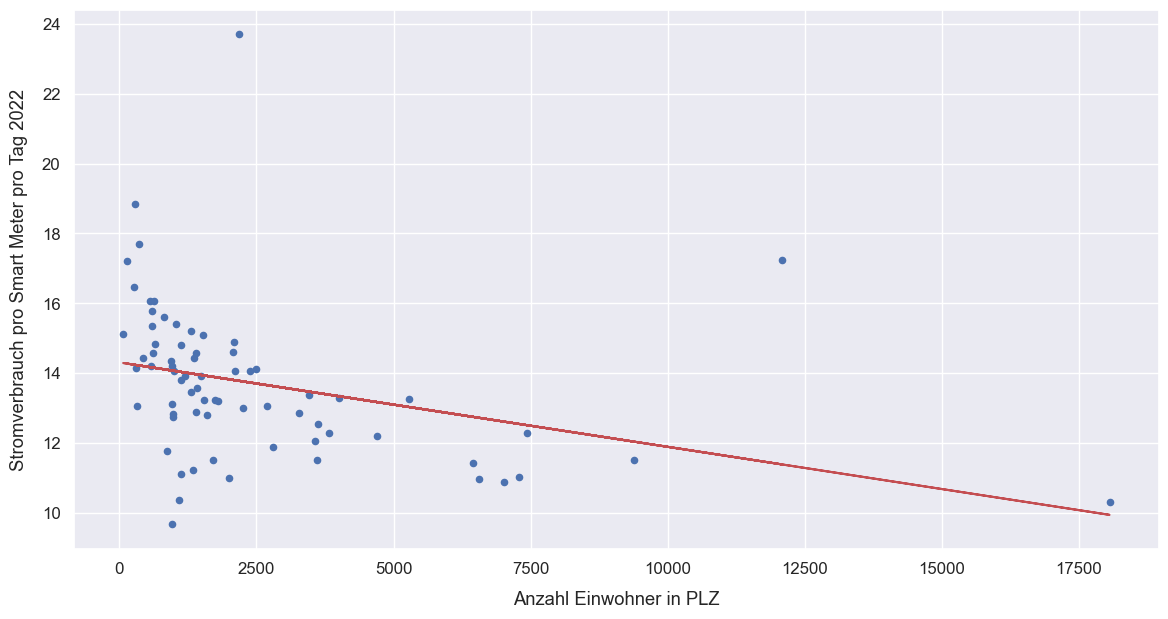

In [60]:
# Stromverbrauch & Gemeindegrösse

df_area.plot.scatter(x = "num_habits", y = 'mean_perArea_perDay', figsize = (14, 7)) # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag 

m, b = np.polyfit(df_area["num_habits"], df_area["mean_perArea_perDay"], 1) # Korrelationsgerade; m = slope, b=intercept
plt.plot(df_area["num_habits"], m*df_area["num_habits"] + b, color="r") # Hinzufügen Korrelation zu Grafik

plt.xlabel("Anzahl Einwohner in PLZ",  labelpad=10) # Umbenennen X-Achse
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag 2022",  labelpad=10) # Umbenennen Y-Achse

#### Top 10 / Bottom 10 Gemeinden

In [64]:
#df_area=df_rollout.groupby(['area_code', 'ortbez18', 'num_habits'])[['kwh_perDay']].mean() # Durchschnittlicher Tagesverbrauch pro Gemeinde 2022
print(df_area.nlargest(10, 'mean_perArea_perDay')) # Top 10
print(df_area.nsmallest(10, 'mean_perArea_perDay')) # Bottom 10

                ortbez18  area_code  num_w  num_m  num_f  num_habits  \
2994716     Hergiswil LU       6133   1023   1041    113        2177   
1200842       Herlisberg       6028    133    139     20         292   
2527777   Steinhuserberg       6114    163    177     22         362   
6911036  Urswil/Hochdorf       6280   5453   5549   1089       12091   
2927616         Rohrmatt       6132     49     81      8         138   
2793697           Daiwil       6126    118    134     20         272   
664231           Sigigen       6019    265    273     22         560   
2460587           Romoos       6113    293    295     41         629   
2726601         Menzberg       6125    269    297     36         602   
3217239     Fischbach LU       6145    351    405     50         806   

         mean_perArea_perDay  meanSM_perarea  num_habits_perSM  
2994716            23.692735       35.919393         60.607928  
1200842            18.844917      133.032158          2.194958  
2527777     

Text(0, 0.5, 'Stromverbrauch pro Smart Meter pro Tag 2022')

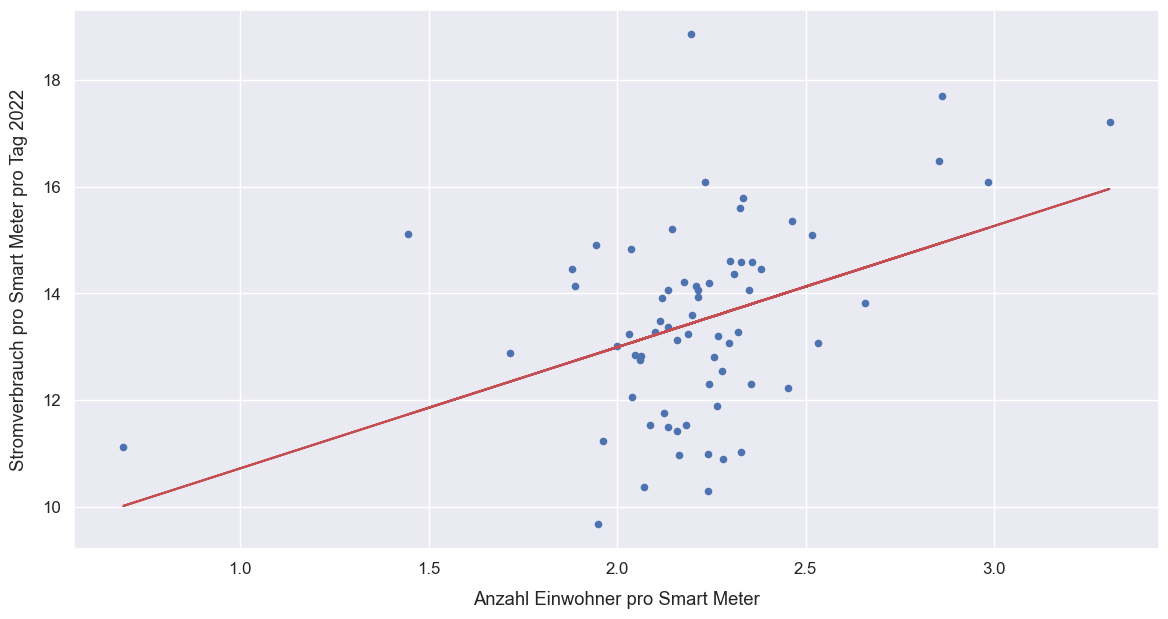

In [69]:
# Stromverbrauch & Anzahl Einwohner pro SM

df_area = df_area[df_area['num_habits_perSM'] <= 5] # Ausschluss von nicht abgeschlossenen Rollouts
df_area.plot.scatter(x = "num_habits_perSM", y = 'mean_perArea_perDay', figsize = (14, 7)) # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag 

m, b = np.polyfit(df_area["num_habits_perSM"], df_area["mean_perArea_perDay"], 1) # Korrelationsgerade; m = slope, b=intercept
plt.plot(df_area["num_habits_perSM"], m*df_area["num_habits_perSM"] + b, color="r") # Hinzufügen Korrelation zu Grafik

plt.xlabel("Anzahl Einwohner pro Smart Meter",  labelpad=10) # Umbenennen X-Achse
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag 2022",  labelpad=10) # Umbenennen Y-Achse

# !!! Zahlen zum Smart Meter-Rollout prüfen !!!

Text(0, 0.5, 'Anzahl Einwohner pro SM')

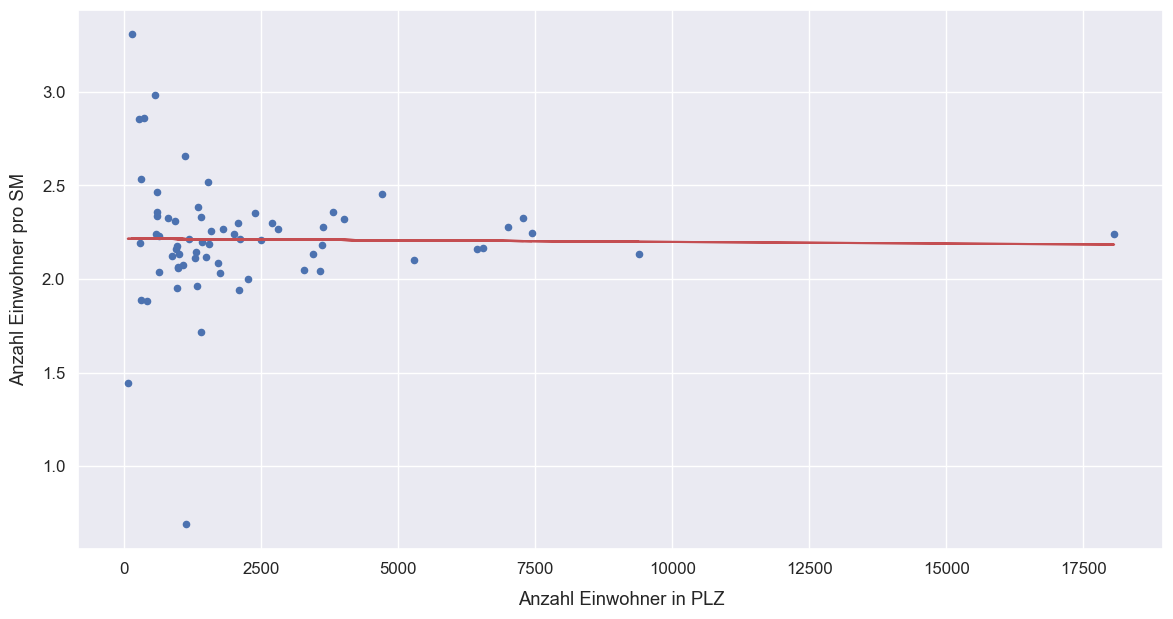

In [70]:
# Gemeindegrösse & Einwohner pro SM

df_area.plot.scatter(x = "num_habits", y = 'num_habits_perSM', figsize = (14, 7)) # Scatterplot Gemeindegrösse & Verbrauch pro Smart Meter pro Tag 

m, b = np.polyfit(df_area["num_habits"], df_area["num_habits_perSM"], 1) # Korrelationsgerade; m = slope, b=intercept
plt.plot(df_area["num_habits"], m*df_area["num_habits"] + b, color="r") # Hinzufügen Korrelation zu Grafik

plt.xlabel("Anzahl Einwohner in PLZ",  labelpad=10) # Umbenennen X-Achse
plt.ylabel("Anzahl Einwohner pro SM",  labelpad=10) # Umbenennen Y-Achse

### Daten-Modellierung OLS

<AxesSubplot: >

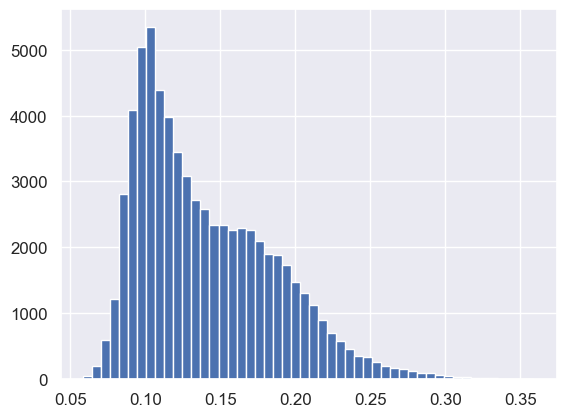

In [50]:
# Histogramm

df_data = pd.read_pickle("Dataset04.pkl") # Neueinlesen Daten 
df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene
df_datashort['kwh_persmdt'].hist(bins=50) # Histogramm

#### Schätzung 15-Minuten-Intervalle

In [51]:
# Datenvorbereitung & Dummy-Variablen 

df_time=df_data.drop_duplicates(subset=['date', 'timestamp']) # Kopie 
df_data['hour'] = df_data['timestamp'].dt.hour # Variable für Stunde

df_datashort = pd.get_dummies(data=df_datashort, columns=['weekday']) # Dummies für weekdays
df_datashort = pd.get_dummies(data=df_datashort, columns=['month']) # Dummies für months
df_datashort = pd.get_dummies(data=df_datashort, columns=['timestamp']) # Dummies für Zeitfenster
df_datashort = pd.get_dummies(data=df_datashort, columns=['year']) # Dummies für years

df_datashort= pd.concat([df_datashort, df_time['timestamp']], axis=1) # Hinzufügen der urspünglichen Zeitfenster im Long-Format

In [52]:
# OLS-Modell für Verbrauchschätzung in 15-Minuten-Intervall mit statsmodels

x = df_datashort[df_datashort.columns[~df_datashort.columns.isin(['hour','weekday_Monday','weekday_Tuesday','weekday_Wednesday','weekday_Thursday','weekday_Friday','month_1','timestamp','season','game','airpress','station/location','Start Rollout','Ende Rollout','kwh_permeterarea','kwh_perdatetime','sm_perdatetime','kwh_persmdt','area_code','num_meter','value_kwh','ortbez18','date','num_f','num_m','num_w','num_habits','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22', 'hour_23','weekday_Monday', 'month_1', 'year_2021', 'timestamp_1900-01-01 00:00:00'])]]
y = df_datashort['kwh_persmdt']

x = sm.add_constant(x) # Hinzufügen Konstante
 
model = sm.OLS(y, x).fit() # OLS-Regression
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            kwh_persmdt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     3571.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:16:14   Log-Likelihood:             1.7800e+05
No. Observations:               67092   AIC:                        -3.558e+05
Df Residuals:                   66979   BIC:                        -3.547e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [53]:
# Modell-Predictions

predictions = model.get_prediction(x)
df_pred = predictions.summary_frame(alpha=0.05)

df_datashort['prediction_mean'] = df_pred['mean'] # Hinzufügen Vorhersage zu Dataframe
df_datashort['ci_lower'] = df_pred['obs_ci_lower'] # Hinzufügen unteres Konfidenzintervall zu Dataframe
df_datashort['ci_upper'] = df_pred['obs_ci_upper'] # Hinzufügen oberes Konfidenzintervall zu Dataframe

<function matplotlib.pyplot.show(close=None, block=None)>

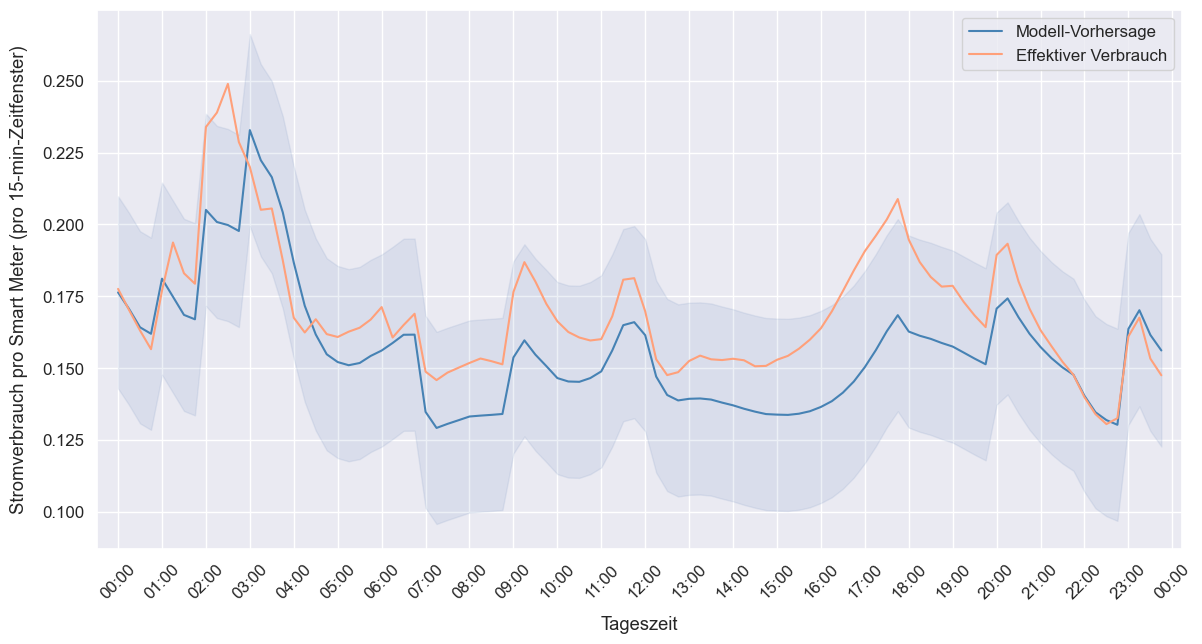

In [54]:
fig, ax = plt.subplots(figsize = (14,7)) # Grafik-Grösse

df_game=df_datashort.loc[(df_datashort['date'] == gamedate)] # Auszug Datum Nati-Spiel
x = df_game['timestamp']

ax.plot(x, df_game['prediction_mean'], color = 'steelblue', label='Modell-Vorhersage')
ax.plot(x, df_game['kwh_persmdt'], color = 'lightsalmon', label='Effektiver Verbrauch')

ax.fill_between(
    x, df_game['ci_lower'], df_game['ci_upper'], color='b', alpha=.1) # Range für Konfidenzintervall

plt.xlabel("Tageszeit", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter (pro 15-min-Zeitfenster)", labelpad=10) # Y-Label

ax.xaxis.set_major_locator(md.MinuteLocator(byminute = [0, 60])) # Abstand X-Tick-Labels
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M')) # Format X-Tick-Labels
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 45) # Rotation X-Tick-Labels

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Schätzung Tagesverbrauch

In [78]:
df_data = pd.read_pickle("Dataset04.pkl") # Neueinlesen Daten 

In [79]:
# Datenaufbereitung für Verbrauch-Schätzung pro Tag

df_datashort=df_data.drop_duplicates(subset=['date', 'timestamp']) # Löschen Gemeinde-Ebene um Verbrauchsdaten pro Tag zu aggregieren
df_datashort['kwh_persmday']=df_datashort.groupby('date')['kwh_persmdt'].transform('sum') # Neue Spalte mit Verbrauch pro Smart Meter pro Tag

df_datashort=df_datashort.drop_duplicates(subset=['date']) # Löschen Zeit-Ebene für aggregierte Verbrauchsdaten pro Tag

df_datashort = pd.get_dummies(data=df_datashort, columns=['weekday']) # Dummies für weekdays
df_datashort = pd.get_dummies(data=df_datashort, columns=['month']) # Dummies für months
df_datashort = pd.get_dummies(data=df_datashort, columns=['year']) # Dummies für years

C:\Users\ckw-stea\AppData\Local\Temp\ipykernel_20176\2943325938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datashort['kwh_persmday']=df_datashort.groupby('date')['kwh_persmdt'].transform('sum') # Neue Spalte mit Verbrauch pro Smart Meter pro Tag


In [80]:
# OLS-Modell für Verbrauch-Schätzung pro Tag mit statsmodels

x = df_datashort[['weekday_Saturday','weekday_Sunday', 'daytemp', 'holiday', 'schoolhol', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8','month_9','month_10','month_11','month_12','year_2022']]
y = df_datashort['kwh_persmday']

x = sm.add_constant(x) # Hinzufügen Konstante
 
model = sm.OLS(y, x).fit(cov_type = "HC0") # OLS mit robusten Standard-Fehlern
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           kwh_persmday   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     1148.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:52:11   Log-Likelihood:                -753.15
No. Observations:                 699   AIC:                             1542.
Df Residuals:                     681   BIC:                             1624.
Df Model:                          17                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               20.3453      0.077  

In [81]:
# Modell-Predictions

predictions = model.get_prediction(x)
df_pred = predictions.summary_frame(alpha=0.05)

df_datashort['prediction_mean'] = df_pred['mean'] # Hinzufügen Vorhersage zu Dataframe
df_datashort['ci_lower'] = df_pred['obs_ci_lower'] # Hinzufügen unteres Konfidenzintervall zu Dataframe
df_datashort['ci_upper'] = df_pred['obs_ci_upper'] # Hinzufügen oberes Konfidenzintervall zu Dataframe

<function matplotlib.pyplot.show(close=None, block=None)>

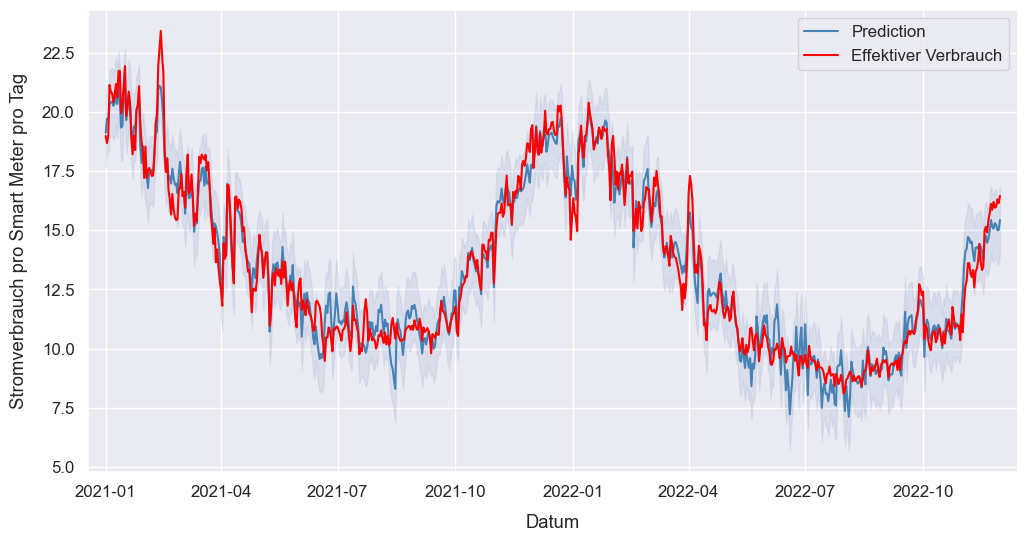

In [82]:
# Vorhersage gemäss Modell vs. effektiver Stromverbrauch

fig, ax = plt.subplots(figsize = (12,6)) # Grafik-Grösse
df_datashort = df_datashort.sort_values(['date'], ascending=[True])

x = df_datashort['date'] # Index definieren

ax.plot(x, df_datashort['prediction_mean'], color = 'steelblue', label='Prediction')
ax.plot(x, df_datashort['kwh_persmday'], color = 'red', label='Effektiver Verbrauch') 

ax.fill_between(
    x, df_datashort['ci_lower'], df_datashort['ci_upper'], color='b', alpha=.1) # Range für Konfidenzintervall

plt.xlabel("Datum", labelpad=10) # X-Label
plt.ylabel("Stromverbrauch pro Smart Meter pro Tag", labelpad=10) # Y-Label

plt.margins(x=0.02) # Anpassen Seitenrand
ax.legend() # Hinzufügen Legende

plt.show

#### Erklärung Verbrauch pro Gemeinde

In [43]:
df_area=df_rollout[['area_code', 'num_w','num_m', 'num_f', 'num_habits', 'mean_perArea_perDay', 'meanSM_perarea','num_habits_perSM']]
df_area=df_area.drop_duplicates(subset=['area_code']) # Löschen Zeit-Ebene

In [71]:
# OLS-Modell für Verbrauchschätzung pro Gemeinde

x = df_area[['num_habits_perSM', 'num_habits']]
y = df_area['mean_perArea_perDay']

x = sm.add_constant(x) # Hinzufügen Konstante
 
model = sm.OLS(y, x).fit() # OLS-Regression
 
print_model = model.summary()
print(print_model)

                             OLS Regression Results                            
Dep. Variable:     mean_perArea_perDay   R-squared:                       0.440
Model:                             OLS   Adj. R-squared:                  0.423
Method:                  Least Squares   F-statistic:                     25.17
Date:                 Wed, 21 Dec 2022   Prob (F-statistic):           8.61e-09
Time:                         10:12:10   Log-Likelihood:                -115.35
No. Observations:                   67   AIC:                             236.7
Df Residuals:                       64   BIC:                             243.3
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.3561   